In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/graduate_project

/content/drive/My Drive/graduate_project


In [0]:
import os
import pandas
import numpy
import random
import copy
import time

import keras.utils.np_utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

from IPython.display import SVG

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import itertools

import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [0]:
CSV_PATH = r"""/content/drive/My Drive/graduate_project/Jfile"""
folder_list = os.listdir(CSV_PATH)
csv_list = list()



for file_name in folder_list:
    if file_name.split(".")[-1] == 'csv':
        f = open(CSV_PATH + "/" + file_name)
        temp_list = [f.read(), file_name.split(".")[0]]
        csv_list.append(temp_list)



def making_df_faster(csv_file_list, column_index=None, split_idx=1):
    
    if column_index == None:
        # column_index = numpy.arange(len(csv_file_list[0][0].split("\n")[0].split(",")))
        column_index = csv_file_list[0][0].split("\n")[0].split(",")
        column_index_2 = [item.replace('"', "") for item in column_index]
    column_index = numpy.hstack((column_index_2, "class_front", "class_back", 'class_combined'))
    
    result_df = pandas.DataFrame(columns=column_index)
    
    row_count = 0
    
    for csv_idx, csv_file in enumerate(csv_file_list):
        one_file_df = pandas.DataFrame(columns=column_index)
        for idx, line in enumerate(csv_file[0].split("\n")):
            if line != "" and idx != 0:
                one_file_df.loc[idx, one_file_df.columns[0]] = line.split(",")[0].replace('"', "")
                temp_data = numpy.array(line.split(",")[1:]).astype(numpy.float)
                temp_data[temp_data < 0] = 0
                one_file_df.loc[idx, one_file_df.columns[1:-3]] = temp_data
                one_file_df.loc[idx, 'class_front'] = int(csv_file[1].split("f")[0][split_idx:])
                one_file_df.loc[idx, 'class_back'] = int(csv_file[1].split("f")[1])
                one_file_df.loc[idx, 'class_combined'] = csv_file[1].split("f")[0][split_idx:] + "_" + csv_file[1].split("f")[1]
                                                           
                row_count += 1
            if row_count % 100 == 0:
                print(row_count)
        result_df = result_df.append(one_file_df)
        print(csv_idx, "th csv is combined complete \n\n\n\n")
    return result_df.reset_index(drop=True)


def deleting_non_detected_columns(given_df, final_data_type='float32'):
    str_df = given_df
#     str_df = None
#     if given_df.dtypes[1] != 'str':
#         str_df = given_df
#         str_df.loc[:, str_df.columns[1:]] = str_df.loc[:, str_df.columns[1:]].astype('str')
    
#     else:
#         str_df = given_df
    
    target_columns = str_df.describe().loc['unique', ][str_df.describe().loc['unique'] == 1].index
    
    for col in target_columns:
        str_df = str_df.drop(columns=col)
    
    final_df = str_df
    final_df.loc[:, final_df.columns[1:-3]] = final_df.loc[:, final_df.columns[1:-3]].astype(final_data_type)
    return final_df


def deleting_before_camera_set(given_df, desire_type='float32', target_column='class_combined', cutting_idx_rank=5):
    cal_df = given_df
#     cal_df = None
#     if given_df.dtypes[2] != desire_type:
#         cal_df = given_df
#         cal_df.loc[:, cal_df.columns[1:-3]] = cal_df.loc[:, cal_df.columns[1:-3]].astype(desire_type)
    
#     else:
#         cal_df = given_df
        
    final_df = pandas.DataFrame(columns=cal_df.columns)
    
    for cls in set(cal_df.loc[:, target_column]):
        max_value_idx_list = cal_df.loc[cal_df.loc[:, target_column] == cls].loc[:, cal_df.columns[3:-2:3]].astype('float32').idxmax()
        cutting_idx = max_value_idx_list.sort_values()[cutting_idx_rank]
        final_df = final_df.append(cal_df.loc[cal_df.loc[:, target_column] == cls][cutting_idx:])
    
    return final_df


def normalization_df(given_df, freq_threshold=0.2, z_axis_threshold=100):
    cal_df = given_df
    
    cls_list = given_df.columns
    df_analysis = given_df.describe(include=['freq', 'count'])
    
    threshold_col = df_analysis.loc['freq'][df_analysis.loc['freq'] > df_analysis.loc['count'] * freq_threshold]
    threshold_col = threshold_col.index
#     print(threshold_col.index)
    
    z_col = given_df.iloc[0, 1:-3] > z_axis_threshold
    z_col = z_col[z_col].index
    
    for col in threshold_col.to_list():
        cal_df.drop(columns=col)
    for col in z_col.to_list():
        cal_df.loc[:, col] = cal_df.loc[:, col] / cal_df.loc[:, col].max()
        
        
    return cal_df


def normalization_df_ver2(given_df):
    cal_df = given_df 
        
    z_df = cal_df.iloc[:, 3:-3:3]
    z_max = z_df.max()
    
    cal_df.iloc[:, 3:-3:3] = cal_df.iloc[:, 3:-3:3] / z_max
    return cal_df


def chunking_data(given_df, chunking_length=60, class_column_name='class_combined'):
    
    np_list = list()
    
    for cls in set(given_df.loc[:, class_column_name]):
        get_df = given_df[given_df.loc[:, class_column_name] == cls]
        np_list.append(get_df.to_numpy())
        
    chunked_data = list()
    chunked_label = list()
    for data in np_list:
        for idx in range(len(data) - chunking_length):
            chunked_data.append(numpy.array(data[idx:idx + chunking_length, 1:-3]))
            chunked_label.append(int(data[0, -3]))
    
    return numpy.array(chunked_data), np_utils.to_categorical(chunked_label)


def preprocessing(given_df, chk_len=60):
    print("deleting data before camera set")
    cal_df = deleting_before_camera_set(given_df)
    print("deleting data before camera set success\n\n")
    print("deleting undetected data")
    cal_df = deleting_non_detected_columns(cal_df)
    print("deleting undetected data done\n\n")
    print("normalizing data")
    cal_df = normalization_df_ver2(cal_df)
    print("normalizing data done \n\n")
    return chunking_data(cal_df, chk_len), cal_df

def making_df_faster_2(csv_file_list, column_index=None, split_idx=1):
    
    if column_index == None:
        # column_index = numpy.arange(len(csv_file_list[0][0].split("\n")[0].split(",")))
        column_index_2 = [idx + 1 for idx in range(len(csv_file_list[0][0].split("\n")[0].split(",")))]
#         column_index_2 = [item.replace('"', "") for item in column_index]
    column_index = numpy.hstack((column_index_2, "class_front", "class_back", 'class_combined'))
    
    result_df = pandas.DataFrame(columns=column_index)
    
    row_count = 0
    
    for csv_idx, csv_file in enumerate(csv_file_list):
        one_file_df = pandas.DataFrame(columns=column_index)
        for idx, line in enumerate(csv_file[0].split("\n")):
            if line != "" and idx != 0:
                one_file_df.loc[idx, one_file_df.columns[0]] = line.split(",")[0].replace('"', "")
#                 print(one_file_df, "\n" * 10, one_file_df.loc[idx, one_file_df.columns[1:]])
                temp_data = numpy.array(line.split(",")[1:]).astype(numpy.float)
                one_file_df.loc[idx, one_file_df.columns[1:-3]] = temp_data
                one_file_df.loc[idx, 'class_front'] = int(csv_file[1].split("f")[0][split_idx:])
                one_file_df.loc[idx, 'class_back'] = int(csv_file[1].split("f")[1])
                one_file_df.loc[idx, 'class_combined'] = csv_file[1].split("f")[0][split_idx:] + "_" + csv_file[1].split("f")[1]
                                                           
                row_count += 1
            if row_count % 100 == 0:
                print(row_count)
        result_df = result_df.append(one_file_df)
        print(csv_idx, "th csv is combined complete \n\n\n\n")
    return result_df.reset_index(drop=True)


In [0]:
df_faster_version = making_df_faster(csv_list)

0
0 th csv is combined complete 




100
1 th csv is combined complete 




200
2 th csv is combined complete 




300
3 th csv is combined complete 




400
4 th csv is combined complete 




500
5 th csv is combined complete 




600
6 th csv is combined complete 




700
7 th csv is combined complete 




800
8 th csv is combined complete 




9 th csv is combined complete 




900
10 th csv is combined complete 




1000
11 th csv is combined complete 




1100
12 th csv is combined complete 




1200
13 th csv is combined complete 




14 th csv is combined complete 




1300
15 th csv is combined complete 




1400
16 th csv is combined complete 




17 th csv is combined complete 




1500
18 th csv is combined complete 




1600
19 th csv is combined complete 




1700
20 th csv is combined complete 




1800
21 th csv is combined complete 




22 th csv is combined complete 




1900
23 th csv is combined complete 




2000
24 th csv is combined complete 




2100
25 th csv is

In [0]:
# 학부생 데이터
csv_list_2 = list()
CSV_PATH_2 = r"""/content/drive/My Drive/graduate_project/Gfile"""

for file_name in os.listdir(CSV_PATH_2):
    if file_name.split(".")[-1] == 'csv':
        f = open(CSV_PATH_2 + "/" + file_name)
        temp_list = [f.read(), file_name.split(".")[0]]
        csv_list_2.append(temp_list)

        

df_faster_gfile = making_df_faster_2(csv_list_2, split_idx=2)

0
100
0 th csv is combined complete 




200
1 th csv is combined complete 




300
2 th csv is combined complete 




400
3 th csv is combined complete 




500
4 th csv is combined complete 




600
5 th csv is combined complete 




700
6 th csv is combined complete 




800
900
7 th csv is combined complete 




1000
8 th csv is combined complete 




1100
9 th csv is combined complete 




1200
10 th csv is combined complete 




1300
11 th csv is combined complete 




1400
12 th csv is combined complete 




1500
13 th csv is combined complete 




1600
1700
14 th csv is combined complete 




1800
15 th csv is combined complete 




1900
16 th csv is combined complete 




2000
17 th csv is combined complete 




2100
18 th csv is combined complete 




2200
19 th csv is combined complete 




2300
20 th csv is combined complete 




2400
2500
21 th csv is combined complete 




2600
22 th csv is combined complete 




2700
23 th csv is combined complete 




2800
24 th csv is 

In [0]:
target_joint = ['shoulder', 'elbow', 'wrist']
joint_name = df_faster_version.columns.to_numpy()

temp_array = list()
for joint in joint_name:
    joint_flag = False
    for target in target_joint:
        if target in joint:
            temp_array.append(True)
            joint_flag = True
    if not joint_flag:
        temp_array.append(False)
        
joint_name[temp_array]

array(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_wrist_x',
       'left_wrist_y', 'left_wrist_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'right_wrist_x', 'right_wrist_y',
       'right_wrist_z', 'v_left_shoulder_x', 'v_left_shoulder_y',
       'v_left_shoulder_z', 'v_left_elbow_x', 'v_left_elbow_y',
       'v_left_elbow_z', 'v_left_wrist_x', 'v_left_wrist_y',
       'v_left_wrist_z', 'v_right_shoulder_x', 'v_right_shoulder_y',
       'v_right_shoulder_z', 'v_right_elbow_x', 'v_right_elbow_y',
       'v_right_elbow_z', 'v_right_wrist_x', 'v_right_wrist_y',
       'v_right_wrist_z', 'a_left_shoulder_x', 'a_left_shoulder_y',
       'a_left_shoulder_z', 'a_left_elbow_x', 'a_left_elbow_y',
       'a_left_elbow_z', 'a_left_wrist_x', 'a_left_wrist_y',
       'a_left_wrist_z', 'a_right_shoulder_x', 'a_right_shoulder_y',
       'a_righ

In [0]:
joint_base = list(joint_name[temp_array])
joint_base.extend(joint_name[-3:])

target_df = df_faster_version.loc[:, joint_base]
target_df.iloc[:, 2:-3:3] = target_df.iloc[:, 2:-3:3] / numpy.max(target_df.iloc[:, 2:-3:3].to_numpy())

time_target_df = target_df
np_time = df_faster_version.loc[:, 'time'].to_numpy()
np_time_split = [item.split(":") for item in np_time]
np_time_sum = [3600*int(time[0]) + 60*int(time[1]) + float(time[2]) for time in np_time_split]

In [0]:
# Extracted Joint Coordinates(Left/Right Sho/Elb/Wrist) /Velocity/Acceleration
joint_base = list(joint_name[temp_array])
joint_base.extend(joint_name[-3:])

target_df = df_faster_version.loc[:, joint_base]

In [0]:
target_df.iloc[:, 2:-3:3] = target_df.iloc[:, 2:-3:3] / numpy.max(target_df.iloc[:, 2:-3:3].to_numpy())

In [0]:
# time data 
time_target_df = target_df
np_time = df_faster_version.loc[:, 'time'].to_numpy()
np_time_split = [item.split(":") for item in np_time]
np_time_sum = [3600*int(time[0]) + 60*int(time[1]) + float(time[2]) for time in np_time_split]
time_target_df['time'] = np_time_sum

In [0]:
# Add time data into table
time_target_df.head()

,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_elbow_x,left_elbow_y,left_elbow_z,left_wrist_x,left_wrist_y,left_wrist_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_elbow_x,right_elbow_y,right_elbow_z,right_wrist_x,right_wrist_y,right_wrist_z,v_left_shoulder_x,v_left_shoulder_y,v_left_shoulder_z,v_left_elbow_x,v_left_elbow_y,v_left_elbow_z,v_left_wrist_x,v_left_wrist_y,v_left_wrist_z,v_right_shoulder_x,v_right_shoulder_y,v_right_shoulder_z,v_right_elbow_x,v_right_elbow_y,v_right_elbow_z,v_right_wrist_x,v_right_wrist_y,v_right_wrist_z,a_left_shoulder_x,a_left_shoulder_y,a_left_shoulder_z,a_left_elbow_x,a_left_elbow_y,a_left_elbow_z,a_left_wrist_x,a_left_wrist_y,a_left_wrist_z,a_right_shoulder_x,a_right_shoulder_y,a_right_shoulder_z,a_right_elbow_x,a_right_elbow_y,a_right_elbow_z,a_right_wrist_x,a_right_wrist_y,a_right_wrist_z,class_front,class_back,class_combined,time
0,0.57303,0.388334,0.891848,0.583741,0.471503,0.888174,0.593331,0.549914,0.866212,0.492819,0.384979,0.900389,0.481733,0.466622,0.891794,0.479286,0.545974,0.873332,2.53404e-05,0.435001,2.17078e-09,1.21489e-05,0,9.24943e-10,5.93617e-06,0,6.73257e-10,0,0.303347,1.68755e-08,0,0,1.44971e-08,0,0.0118434,1.40189e-08,5.49087e-07,0.0288912,0,0,0,0,0,0.00143605,0,0,0.0126192,1.71128e-10,0,0.000645726,2.25602e-10,0,0.00530899,2.3682e-10,30,5,30_5,71491.946
1,0.572059,0.38896,0.881831,0.583914,0.472921,0.886814,0.592835,0.552401,0.866068,0.493132,0.384983,0.893282,0.484514,0.468328,0.888118,0.480059,0.549102,0.873642,1.89697e-05,0,1.55034e-09,4.29697e-05,0,0,7.53636e-05,0,0,1.21212e-07,0,2.4922e-08,5.1697e-05,0,6.92725e-09,9.47879e-05,0.0318345,3.27991e-09,0,0,0,9.33962e-07,0,0,2.10386e-06,0.00121737,0,3.73095e-06,0,2.43833e-10,5.1836e-06,0,0,6.11414e-06,0.000605789,0,30,5,30_5,71491.979
2,0.570434,0.393238,0.88278,0.584655,0.476657,0.883028,0.593308,0.555867,0.860665,0.493733,0.38611,0.893962,0.485228,0.469351,0.887484,0.481145,0.549099,0.868636,0.000129636,0.0972049,6.64048e-09,0.000113212,0,4.2388e-09,0.00010503,0,3.78176e-09,3.41515e-05,0.0696837,6.39852e-09,3.1e-05,0,9.7322e-09,0,0,1.03774e-08,3.35354e-06,0.0340492,1.54247e-10,2.12856e-06,0,2.63143e-10,8.9899e-07,0,2.87583e-10,1.03122e-06,0.0241818,0,0,0.00944997,8.49986e-11,0,0,2.15076e-10,30,5,30_5,71492.120
3,0.571466,0.391258,0.882873,0.585487,0.47474,0.880131,0.593919,0.554487,0.857629,0.495508,0.390423,0.891847,0.484322,0.473598,0.887422,0.481721,0.552281,0.862329,0,0.0095363,7.45598e-09,0,0,5.47548e-09,0,0,5.06325e-09,0.000130697,0,0,0.000128697,0,5.16183e-09,9.64242e-05,0,7.84132e-09,0,0,2.47121e-11,0,0.00275549,3.74754e-11,0,0.00734865,3.88332e-11,2.92562e-06,0,0,2.96051e-06,0.00177288,0,2.9247e-06,0,0,30,5,30_5,71492.450
4,0.571339,0.391789,0.882465,0.587218,0.473431,0.880733,0.594195,0.553476,0.856459,0.494497,0.387231,0.886985,0.484752,0.470141,0.886841,0.481475,0.548696,0.85951,1.56176e-05,0,1.50561e-08,0,0.0598791,2.40063e-09,0,0,0,0,0,3.74011e-09,0,0,0,0,0,0,2.22405e-06,0,2.23534e-10,5.76203e-07,0.0104947,0,3.55379e-07,0.00572829,0,0,0,3.48801e-10,0,0,0,0,0.0107601,0,30,5,30_5,71492.790


In [0]:
def calculate_velo_accele(given_df, columns_length=18):
    if 'time' not in list(given_df.columns):
        raise Exception("DataFrame should have 'time' column. Check Dataframe")
    
    class_comb = numpy.unique(given_df.loc[:, 'class_combined'].to_numpy())
    
    cal_np = given_df.to_numpy()
    velo_final_data = list()
    accele_final_data = list()
    position_final_data = list()
    etc_final_data = list()
    
    for idx, cls in enumerate(class_comb):
        temp_data = cal_np[cal_np[:, -2] == cls]
        temp_time = temp_data[1:, -1] - temp_data[:-1, -1]
        final_time = numpy.repeat(temp_time, columns_length).reshape((-1, temp_data.shape[0] - 1, columns_length))
        
        position_data = temp_data[2:, :columns_length]
        etc_data = temp_data[2:, columns_length*3:-1]
        
        velo_data = (temp_data[1:, :columns_length] - temp_data[:-1, :columns_length]) / final_time
        cp_velo = copy.deepcopy(velo_data)
        accele_data = (cp_velo[:, 1:] - cp_velo[:, :-1]) / final_time[0][1:]

        
        velo_final_data.extend(list(velo_data[0][1:]))
        accele_final_data.extend(list(accele_data[0]))
        position_final_data.extend(list(position_data))
        etc_final_data.extend(etc_data)
    temp_sum_data = numpy.hstack((
                                  numpy.array(velo_final_data) / numpy.max(velo_final_data),
                                  numpy.array(accele_final_data) / numpy.max(accele_final_data),
                                  etc_final_data))

    return pandas.DataFrame(temp_sum_data, columns=given_df.columns[columns_length:-1])

In [0]:
# Check Velocity and Acceleration data
calculated_df = calculate_velo_accele(target_df)
calculated_df.head()

,v_left_shoulder_x,v_left_shoulder_y,v_left_shoulder_z,v_left_elbow_x,v_left_elbow_y,v_left_elbow_z,v_left_wrist_x,v_left_wrist_y,v_left_wrist_z,v_right_shoulder_x,v_right_shoulder_y,v_right_shoulder_z,v_right_elbow_x,v_right_elbow_y,v_right_elbow_z,v_right_wrist_x,v_right_wrist_y,v_right_wrist_z,a_left_shoulder_x,a_left_shoulder_y,a_left_shoulder_z,a_left_elbow_x,a_left_elbow_y,a_left_elbow_z,a_left_wrist_x,a_left_wrist_y,a_left_wrist_z,a_right_shoulder_x,a_right_shoulder_y,a_right_shoulder_z,a_right_elbow_x,a_right_elbow_y,a_right_elbow_z,a_right_wrist_x,a_right_wrist_y,a_right_wrist_z,class_front,class_back,class_combined
0,-0.00100718,0.00248253,-0.00475848,0.00350922,0.00548047,7.56111e-06,0.00188089,0.00470737,-0.00479822,0.000270019,0.00529053,0.00100864,6.77615e-05,0.00732851,0.00271541,0.00062012,0.000554412,-0.00444397,-0.0010056,0.00147269,-0.00356059,0.000749617,0.00469157,0.00207841,0.00226363,0.00363592,-0.00155086,0.000844051,0.00335043,0.000805995,0.000125783,0.00593796,0.00418262,0.000122773,0.00105606,-0.000828543,10,1,10_1
1,-0.00659545,0.00965827,-0.0105457,-0.00496014,0.0108667,-0.00685395,0.00217853,0.0113997,-0.00186872,0.00196395,0.010669,-0.00105716,-0.00045739,0.0102365,-0.00468402,0.0102252,0.00386918,-0.00992015,-0.00529188,0.00679516,-0.0054803,-0.00802018,0.00510055,-0.0064976,0.000281851,0.00633743,0.00277413,0.00160409,0.00509326,-0.00195623,-0.000497299,0.00275376,-0.00700699,0.00909566,0.00313896,-0.00518575,10,1,10_1
2,-0.00209955,0.00346748,-0.0031532,0.00286822,0.00297727,-0.00103198,-0.0301464,-0.156137,0.000412181,0.00399157,0.011457,0.00162266,-0.00210908,0.0103103,0.000981758,0.00656969,0.0010376,-0.00271098,0.00399136,-0.00549604,0.00656292,0.00694984,-0.00700405,0.00516861,-0.0286974,-0.148736,0.00202493,0.00180008,0.000699515,0.00237908,-0.00146633,6.55462e-05,0.00502996,-0.00324529,-0.00251382,0.00640015,10,1,10_1
3,0.000463959,0.00287641,0.00147435,5.73898e-05,0.00256249,-0.00251028,-0.00697183,0.00689992,-0.00159146,-0.00253207,-0.00361418,0.000898696,0.000959724,-0.00337494,0.000557729,-0.0170372,-0.0147575,-0.00447381,0.00148625,-0.00034269,0.00268293,-0.00162964,-0.000240478,-0.000857077,0.013436,0.0945246,-0.00116166,-0.00378223,-0.00873786,-0.000419734,0.00177921,-0.00793435,-0.000245841,-0.0136866,-0.00915757,-0.00102204,10,1,10_1
4,0.00453684,-0.0126534,-0.00131773,0.00113183,-0.0115512,0.00376383,-0.0100668,0.0114866,-0.0149942,0.00222342,0.00522187,-0.00702305,-0.00260458,0.00638017,-7.97299e-05,-0.00878358,-0.0224481,-0.00133944,0.00361582,-0.013787,-0.00247874,0.000953863,-0.0125298,0.00557001,-0.00274766,0.00407198,-0.0118987,0.00422182,0.00784445,-0.00703276,-0.00316431,0.00866037,-0.000565922,0.00732736,-0.00682757,0.00278263,10,1,10_1


In [0]:
# Export from raw data Gfile(학부데이터)
np_df_ver2 = df_faster_gfile.to_numpy()
temp_np = np_df_ver2[np_df_ver2[:, -3] == 10]
temp_np = temp_np[temp_np[:, 0] != '0']
temp_df = pandas.DataFrame(temp_np)
df_faster_gfile.loc[np_df_ver2[:, 0] == temp_np[0][0], :].to_numpy()[0][1:-3]
df_faster_version.loc[df_faster_version.to_numpy()[:, 0] == temp_np[0][0]].to_numpy()[0][62:-3]
target_time_np = df_faster_version.loc[df_faster_version.to_numpy()[:, 0] == temp_np[0][0]].to_numpy()[0]

In [0]:
calculated_df

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Position Data(JC), Velocity, Acceleration 데이터 나누기
position_data = target_df.iloc[:, :18]
velocity_data = target_df.iloc[:, 18:36]
acceleration_data = target_df.iloc[:, 36:]

In [0]:
velocity_data[joint_name[-3:]] = df_faster_version.iloc[:, -3:]
position_data[joint_name[-3:]] = df_faster_version.iloc[:, -3:]

In [0]:
# Chunking data
position_total_data = chunking_data(position_data, 30)
all_feature_total_data = chunking_data(calculated_df, 30)

In [0]:
all_feature_total_data[0].shape

(6192, 30, 35)

In [0]:
model_all_feature_shape = all_feature_total_data[0].shape[1:]
random_index = [i for i in range(all_feature_total_data[0].shape[0])]
random.shuffle(random_index)
np_ran_idx = numpy.array(random_index)

training_ratio = 0.5
test_ratio = 0.2

training_index = list(np_ran_idx[:int(np_ran_idx.shape[0] * training_ratio)])
validation_index = list(np_ran_idx[int(np_ran_idx.shape[0] * training_ratio):-int(np_ran_idx.shape[0] * test_ratio)])

In [0]:
# model_position_shape = (1, *position_total_data[0].shape[1:])
model_position_shape = position_total_data[0].shape[1:]

Model

In [0]:
# JC model
model_position = Sequential()
model_position.add(Conv1D(128, 26, padding='same', input_shape=model_position_shape))
model_position.add(LeakyReLU(0.3))
model_position.add(Conv1D(256, 26, padding='same'))
model_position.add(LeakyReLU(0.3))
model_position.add(Dropout(0.0075))
model_position.add(Flatten())
model_position.add(Dense(128))
model_position.add(LeakyReLU(0.4))
model_position.add(Dense(position_total_data[1].shape[-1], activation='softmax'))

model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('jc_history.csv', append=True, separator=';')

position_history = model_position.fit(position_total_data[0][training_index], position_total_data[1][training_index],
                                      epochs = 100,
                                      validation_data=(position_total_data[0][validation_index],
                                                       position_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = model_position.to_json()
with open("./model_save/jc_model_100.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
model_position.save_weights("./model_save/jc_weight_100.h5")
print("Saved jc model to disk")

Train on 3096 samples, validate on 1858 samples
Epoch 1/100
3096/3096 [==============================] - 3s 1ms/step - loss: 3.3589 - acc: 0.0817 - val_loss: 3.1833 - val_acc: 0.0980
Epoch 2/100
3096/3096 [==============================] - 1s 269us/step - loss: 3.1282 - acc: 0.0833 - val_loss: 3.0686 - val_acc: 0.0936
Epoch 3/100
3096/3096 [==============================] - 1s 284us/step - loss: 3.0729 - acc: 0.0937 - val_loss: 3.0439 - val_acc: 0.0947
Epoch 4/100
3096/3096 [==============================] - 1s 269us/step - loss: 3.0489 - acc: 0.1001 - val_loss: 3.0261 - val_acc: 0.1039
Epoch 5/100
3096/3096 [==============================] - 1s 267us/step - loss: 3.0366 - acc: 0.0924 - val_loss: 3.0122 - val_acc: 0.0893
Epoch 6/100
3096/3096 [==============================] - 1s 283us/step - loss: 3.0230 - acc: 0.0956 - val_loss: 3.0019 - val_acc: 0.0931
Epoch 7/100
3096/3096 [==============================] - 1s 267us/step - loss: 3.0140 - acc: 0.0969 - val_loss: 2.9925 - val_acc: 0.

JCS model

In [0]:
# JCS model
model_all_feature = Sequential()
model_all_feature.add(Conv1D(128, 26, padding='same', input_shape=model_all_feature_shape))
model_all_feature.add(LeakyReLU(0.3))
model_all_feature.add(Conv1D(256, 26, padding='same'))
model_all_feature.add(LeakyReLU(0.3))
model_all_feature.add(Dropout(0.0075))
model_all_feature.add(Flatten())
model_all_feature.add(Dense(128))
model_all_feature.add(LeakyReLU(0.4))
model_all_feature.add(Dense(position_total_data[1].shape[-1], activation='softmax'))

model_all_feature.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('jcs_history.csv', append=True, separator=';')

all_feature_history = model_all_feature.fit(all_feature_total_data[0][training_index], all_feature_total_data[1][training_index],
                                            epochs = 100,
                                            validation_data=(all_feature_total_data[0][validation_index],
                                                             all_feature_total_data[1][validation_index]), callbacks=[csv_logger])

# model save
model_json = model_all_feature.to_json()
with open("./model_save/jcs_model_100.json", "w") as json_file : 
    json_file.write(model_json)
    
# model weight save
model_all_feature.save_weights("./model_save/jcs_weight_100.h5")
print("Saved jcs model to disk")

Train on 3096 samples, validate on 1858 samples
Epoch 1/100
3096/3096 [==============================] - 4s 1ms/step - loss: 3.5521 - acc: 0.0856 - val_loss: 3.5499 - val_acc: 0.0915
Epoch 2/100
3096/3096 [==============================] - 1s 304us/step - loss: 3.5452 - acc: 0.1231 - val_loss: 3.5437 - val_acc: 0.0910
Epoch 3/100
3096/3096 [==============================] - 1s 325us/step - loss: 3.5359 - acc: 0.1160 - val_loss: 3.5343 - val_acc: 0.0936
Epoch 4/100
3096/3096 [==============================] - 1s 301us/step - loss: 3.5211 - acc: 0.1172 - val_loss: 3.5176 - val_acc: 0.0942
Epoch 5/100
3096/3096 [==============================] - 1s 306us/step - loss: 3.4952 - acc: 0.1176 - val_loss: 3.4860 - val_acc: 0.0942
Epoch 6/100
3096/3096 [==============================] - 1s 333us/step - loss: 3.4477 - acc: 0.1176 - val_loss: 3.4273 - val_acc: 0.0942
Epoch 7/100
3096/3096 [==============================] - 1s 337us/step - loss: 3.3688 - acc: 0.1163 - val_loss: 3.3394 - val_acc: 0.

model_load

In [0]:
# jc model load
from keras.models import model_from_json 
json_file = open("./model_save/jc_model_300.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
model_position.load_weights("./model_save/jc_weight_300.h5")
print("Loaded model from disk")

# evaluate
model_position.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])
score = model_position.evaluate(position_total_data[0],position_total_data[1],verbose=0)
print('JC total loss : ' + str(round(score[0], 4)))
print('JC total accuracy : ' + str(round(score[1], 4)))

# JC trainig/validation accuracy check
JC_1dcnn_training_accuracy = numpy.sum(numpy.argmax(model_position.predict(position_total_data[0][training_index]), axis=1) == numpy.argmax(position_total_data[1][training_index], axis=1)) / position_total_data[0][training_index].shape[0]
print("JC_1dcnn_training_accuracy : " + str(round(JC_1dcnn_training_accuracy, 4)))

JC_1dcnn_validation_accuracy = numpy.sum(numpy.argmax(model_position.predict(position_total_data[0][validation_index]), axis=1) == numpy.argmax(position_total_data[1][validation_index], axis=1)) / position_total_data[0][validation_index].shape[0]
print("JC_1dcnn_validation_accuracy : " + str(round(JC_1dcnn_validation_accuracy, 4)))


Loaded model from disk
JC total loss : 1.2292
JC total accuracy : 0.5678
JC_1dcnn_training_accuracy : 0.594
JC_1dcnn_validation_accuracy : 0.5619


In [0]:
# jcs model load
from keras.models import model_from_json 
json_file = open("./model_save/jcs_model_300.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# model weight load 
model_all_feature.load_weights("./model_save/jcs_weight_300.h5")
print("Loaded model from disk")

# evaluate
model_all_feature.compile(loss='categorical_crossentropy', optimizer=Adam(0.0000045), metrics=['accuracy'])
score = model_all_feature.evaluate(all_feature_total_data[0],all_feature_total_data[1],verbose=0)

print('JCS total loss : ' + str(round(score[0], 4)))
print('JCS total accuracy : ' + str(round(score[1], 4)))

# JCS training/validation accuracy check
boolean_result = numpy.argmax(model_all_feature.predict(all_feature_total_data[0][training_index]), axis=1) == numpy.argmax(all_feature_total_data[1][training_index], axis=1)
JCS_1dcnn_training_accuracy = numpy.sum(boolean_result) / all_feature_total_data[0][training_index].shape[0]
print("JCS_1dcnn_training_accuracy is : " + str(round(JCS_1dcnn_training_accuracy, 4)))

boolean_result = numpy.argmax(model_all_feature.predict(all_feature_total_data[0][validation_index]), axis=1) == numpy.argmax(all_feature_total_data[1][validation_index], axis=1)
JCS_1dcnn_validation_accuracy = numpy.sum(boolean_result) / all_feature_total_data[0][validation_index].shape[0]
print("JCS_1dcnn_validation_accuracy is : " + str(round(JCS_1dcnn_validation_accuracy, 4)))

Loaded model from disk
JCS total loss : 2.0109
JCS total accuracy : 0.3193
JCS_1dcnn_training_accuracy is : 0.3517
JCS_1dcnn_validation_accuracy is : 0.2766


In [0]:
def plotting_history_loss(given_history, title='Loss graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['loss'])
    plt.plot(given_history.history['val_loss'])
    plt.legend(['loss', 'val_loss'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.show()
    
    
def plotting_history_acc(given_history, title='Accruacy graph'):
    fontP = FontProperties()
    plt.plot(given_history.history['acc'])
    plt.plot(given_history.history['val_acc'])
    plt.legend(['acc', 'val_acc'], prop=fontP, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(title)
    plt.show()

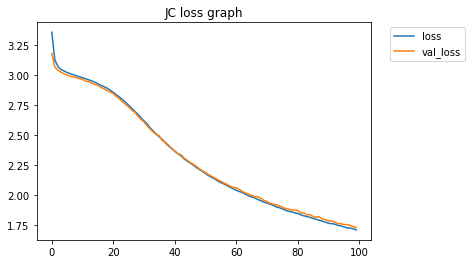

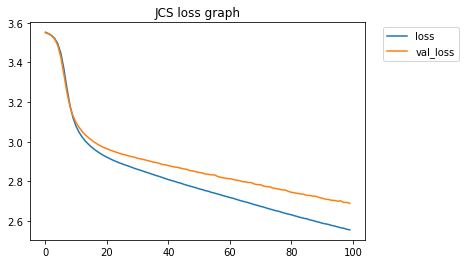

In [0]:
JC_loss = plotting_history_loss(position_history, 'JC loss graph')
JCS_loss = plotting_history_loss(all_feature_history, 'JCS loss graph')

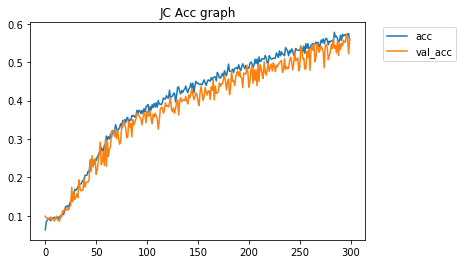

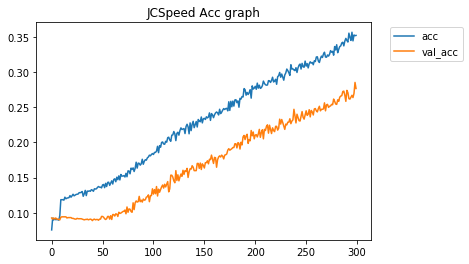

In [0]:
JC_1dcnn_acc = plotting_history_acc(position_history, 'JC Acc graph')
JCS_1dcnn_acc = plotting_history_acc(all_feature_history, 'JCSpeed Acc graph')

F1-Score

In [0]:
from sklearn.metrics import classification_report

# JC_training
print(classification_report(numpy.argmax(position_total_data[1][training_index], axis=1), numpy.argmax(model_position.predict(position_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(position_total_data[1][validation_index], axis=1), numpy.argmax(model_position.predict(position_total_data[0][validation_index]), axis=1)))
# JCS_training
print(classification_report(numpy.argmax(all_feature_total_data[1][training_index], axis=1), numpy.argmax(model_all_feature.predict(all_feature_total_data[0][training_index]), axis=1)))
print(classification_report(numpy.argmax(all_feature_total_data[1][validation_index], axis=1), numpy.argmax(model_all_feature.predict(all_feature_total_data[0][validation_index]), axis=1)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          10       0.59      0.74      0.66        94
          11       0.91      0.52      0.66        56
          12       0.78      0.53      0.63        58
          13       0.64      0.87      0.73        83
          14       0.89      0.69      0.78        85
          15       0.78      0.84      0.81        90
          16       0.64      0.47      0.54        62
          17       0.79      0.75      0.77       111
          18       0.90      0.66      0.76        67
          19       0.78      0.73      0.75        73
          20       0.67      0.77      0.72        96
          21       0.84      0.66      0.74        98
          22       0.93      0.87      0.90        71
          23       1.00      1.00      1.00        88
          24       0.89      1.00      0.94        73
          25       0.96      1.00      0.98       109
          26       0.59      0.49      0.54        53
          27       0.55    

LSTM